# Modeling , Param Tuning, Evulating, Explaining & Prediction

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
import shap
import json
import imblearn
import DATA_PROCESSING as process
%pylab inline
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
#train_df =  pd.read_csv('ctr_dataset_train.csv')

In [4]:
#train_df.to_pickle('train_set.pickle')

In [5]:
SAMPLE = 1000000
df = pd.read_pickle("train_set.pickle").sample(n=SAMPLE)
df.loc[:,"clicked"] = df.loc[:,"clicked"].map({True:1, False:0})
CALC_PARAMS = True


In [6]:
columns_cum =['app_cat','manufacturer','device_model','device_version','user_isp']
columns_dummies=['banner_pos', 'Day_of_Week','state','banner_pos','manufacturer','Month','hour','user_isp','app_cat','device_model','device_version']
features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'device_height', 'device_width', 'device_diag', 'Day_of_Week', 'Month', 'hour']
cat_features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'Day_of_Week', 'Month', 'hour']

### Imputing, Feature engineering,Cardinality reductions , and dummy coding 

In [7]:
%%time
df= df.drop(['op_id', 'resolution','app_id'], axis=1)
df=process.Missing_values(df)
df=process.Feature_engineering(df)
df=process.cumulatively_categorise(df,columns_cum)
#df=process.get_dummies_fun(df,columns_dummies)

summary of null values befor imputing missing data: 
timestamp              0
state                  0
user_isp              12
app_cat                0
banner_pos             0
manufacturer      305795
device_model      305755
device_version         0
device_height          0
device_width           0
clicked                0
dtype: int64
summary of null values after imputing missing data based on device version
timestamp            0
state                0
user_isp             0
app_cat              0
banner_pos           0
manufacturer      1427
device_model      1427
device_version       0
device_height        0
device_width         0
clicked              0
dtype: int64
summary of null values after imputing missing data as a seprate category
Wall time: 22.2 s


In [8]:
configs = pd.read_csv("configuration_01_14_2022__19_05.csv").set_index('index')
configs

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
index,,,,,,,
RF,0.926,0.026316,1.000000,0.778993,-2.555869,0.766859,"{""class_weight"": ""balanced"", ""criterion"": ""gin..."
knn,0.926,0.026316,1.000000,0.760253,-2.555869,0.280000,"{""leaf_size"": 30, ""n_neighbors"": 100, ""weights..."
catboost,0.922,0.026316,0.333333,0.780360,-2.694028,0.173593,"{""min_data_in_leaf"": 100, ""depth"": 4, ""l2_leaf..."


In [9]:
def get_config(model):
    d = configs.loc[model].params
    params = json.loads(d)
    print (params)
    return (params)

# splitting the data test to 3 parts:
1. training: 80%
2. validation: 10% - for param running 
3. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [10]:
train_df, other = train_test_split(df, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)


In [11]:
train_df.shape, dev_val.shape,  dev_test.shape

((800000, 14), (100000, 14), (100000, 14))

In [12]:
dev_val.head()

,state,user_isp,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,clicked,device_diag,Day_of_Week,Month,hour
803899,Colorado,Other,games - action,bottom-left,Motorola,E Play (5th Gen.),8.0.0,720,1280,0,45.0,Tuesday,Oct,day
624862,Florida,Sprint PCS,games - board,bottom,LG,SM-J327T1,7.0,720,1280,0,45.0,Friday,Aug,evening
666323,California,AT&T U-verse,games - arcade,top,LG,MP260,7.0,720,1280,0,45.0,Sunday,Sep,evening
742056,Kentucky,Spectrum,games - action,bottom,Samsung,SM-J700T1,7.1.1,720,1280,0,45.0,Sunday,Oct,evening
896804,Texas,Spectrum,games - casino,top-left,LG,Other,7.0,1080,1920,1,31.0,Saturday,Nov,night


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 566853 to 121958
Data columns (total 14 columns):
state             800000 non-null object
user_isp          800000 non-null object
app_cat           800000 non-null object
banner_pos        800000 non-null object
manufacturer      800000 non-null object
device_model      800000 non-null object
device_version    800000 non-null object
device_height     800000 non-null int64
device_width      800000 non-null int64
clicked           800000 non-null int64
device_diag       800000 non-null float64
Day_of_Week       800000 non-null object
Month             800000 non-null object
hour              800000 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 91.6+ MB


In [14]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']


# exploring the Target Encoder

for classification tasks Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value by encoding for each level the propoprion of rows in which Y=1\
i.e. for click prediction it encodes the ctr for each level over the entire dataset

In [15]:
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X_train, y_train)


TargetEncoder(cols=['state', 'user_isp', 'app_cat', 'banner_pos',
                    'manufacturer', 'device_model', 'device_version',
                    'Day_of_Week', 'Month', 'hour'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0, verbose=0)

In [16]:
X_val_encoded = encoder.fit_transform(X_val, y_val)

In [17]:
X_val_encoded.describe()

,state,user_isp,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,device_diag,Day_of_Week,Month,hour
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,0.067490,0.067490,0.067490,0.067490,0.067490,0.067490,0.067490,1180.698380,1149.955690,40.65304,0.067490,0.067490,0.067490
std,0.006166,0.007896,0.018645,0.070316,0.013466,0.021182,0.009153,518.470104,452.281569,9.44065,0.002204,0.007381,0.001499
min,0.040000,0.052917,0.037756,0.000000,0.048607,0.018182,0.050200,480.000000,320.000000,0.00000,0.064074,0.047970,0.065383
25%,0.063609,0.060126,0.055209,0.000000,0.054821,0.055809,0.064990,720.000000,720.000000,31.00000,0.064743,0.055030,0.065383
50%,0.065782,0.068281,0.063364,0.000000,0.077125,0.063745,0.069170,1080.000000,1080.000000,45.00000,0.067367,0.070708,0.067942
75%,0.071969,0.075174,0.076490,0.138139,0.080501,0.075859,0.074843,1280.000000,1280.000000,45.00000,0.068887,0.073152,0.069160
max,0.093023,0.083161,0.121812,0.148225,0.083618,0.188940,0.075124,3120.000000,3120.000000,64.00000,0.070699,0.073152,0.069160


In [18]:
X_val_encoded.drop_duplicates()

,state,user_isp,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,device_diag,Day_of_Week,Month,hour
803899,0.064065,0.065477,0.045638,0.000000,0.077125,0.064362,0.050200,720,1280,45.0,0.066880,0.073152,0.069160
624862,0.065562,0.058401,0.037756,0.000000,0.080501,0.061507,0.074843,720,1280,45.0,0.064743,0.055030,0.067942
666323,0.071969,0.071726,0.075347,0.134659,0.080501,0.101901,0.074843,720,1280,45.0,0.070699,0.070708,0.067942
742056,0.074419,0.075174,0.045638,0.000000,0.054821,0.051250,0.069170,720,1280,45.0,0.070699,0.073152,0.067942
896804,0.063609,0.075174,0.065214,0.141257,0.080501,0.075859,0.074843,1080,1920,31.0,0.068887,0.070992,0.065383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146165,0.071969,0.077441,0.063364,0.000000,0.054821,0.061507,0.074843,1280,720,45.0,0.070699,0.070992,0.065383
927253,0.065562,0.077441,0.065214,0.138139,0.048607,0.054101,0.069170,1080,1920,31.0,0.064074,0.070708,0.065383
392080,0.060125,0.074121,0.076490,0.000000,0.054821,0.046250,0.064990,1920,1080,31.0,0.067367,0.073152,0.067942
669591,0.066194,0.071726,0.063364,0.138139,0.080501,0.061507,0.074843,720,1280,45.0,0.070699,0.070708,0.069160


# Preparing for pipeline creation

In [19]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [20]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [21]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [22]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_metric = 0
    worst_metric = 1
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g)
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        curr_metric, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best metric", best_metric, ", Grid:", best_grid)
    print ("worst metric", worst_metric, ", Grid:", best_grid)
    return best_grid

In [23]:
def evaulate_pipeline(pipe, X, y, params):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
   
    result = {
        "Accuracy": accuracy_score(y, y_pred, normalize=True),
        "Recall": recall_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "AUC": auc,
        "-LogLoss(higer is better)": -log_loss(y, y_pred),
        "threshold":   best_threshold,
        "params": json.dumps(params)
    }
    return result
    

# Model 1: Random Forest PipeLine

In [24]:
def make_rf_pipe_line(calibration = None, params = None ):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [25]:
# this is a long step, was executed and saved previously

if CALC_PARAMS:


    rf_params_grid ={'min_samples_leaf': [50, 100, 500], 
                     'max_depth': [3,5] ,
                     'class_weight' : ['balanced', None],
                     'n_estimators': [100, 200],
                     'criterion': ["gini"]

                    }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    get_config
    best_rf_params = get_config('RF')


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 100}
Best Threshold: 0.6986846697445616 , with accuracy =  0.93257
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 200}
Best Threshold: 0.7046704325415825 , with accuracy =  0.93258
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 100}
Best Threshold: 0.6986846697445617 , with accuracy =  0.93257
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 200}
Best Threshold: 0.7046704325415822 , with accuracy =  0.93258
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 500, 'n_estimators': 100}
Best Threshold: 0.6986846697445616 , with accuracy =  0.93257
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 500, 'n_estimators': 200}
Best Threshold: 0.70

In [26]:

rf_pipe = make_rf_pipe_line(calibration = None, params = best_rf_params)


Best Threshold: 0.22028116008588416 , with accuracy =  0.93263


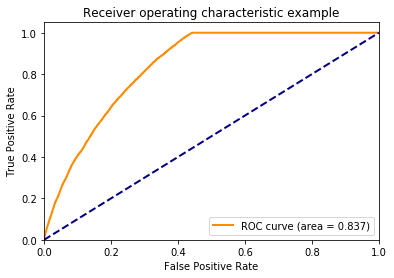

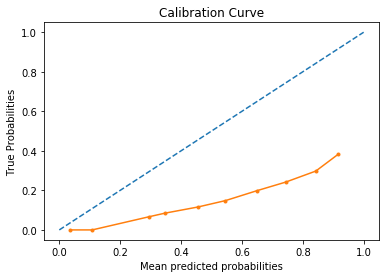

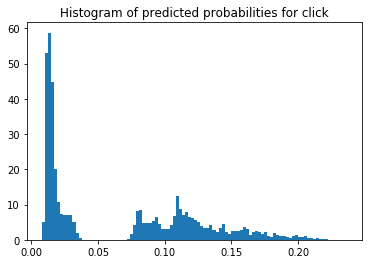

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.93263,0.002963,0.714286,0.836871,-2.326877,0.220281,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."


In [27]:
rf_results = evaulate_pipeline(rf_pipe, X_val, y_val,best_rf_params)
rf_df = pd.DataFrame(rf_results, index= ['RF'])
rf_df

# Model 2: CatBoost 

In [28]:
X_val = dev_val[features]
y_val = dev_val['clicked']

In [29]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)


In [30]:
def make_catboost_pipe_line(train_pool, validation_pool , class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [31]:
catboost_params_grid ={ 
                  'depth': [4,6,8] ,
                  'min_child_samples' : [100,500,1000],
                  'n_estimators': [100,200],
                  'subsample': [0.75,0.95],
                  'l2_leaf_reg':[1,2],
                       
                }


In [32]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
if CALC_PARAMS:

    search_results = model.randomized_search(catboost_params_grid,
                      train_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True,
                      search_by_train_test_split=True,
                      refit=True,
                      shuffle=True,
                      stratified=None,
                      train_size=0.8,
                      verbose=False,
                      log_cout=sys.stdout,
                  log_cerr=sys.stderr)

    best_catboost_params = search_results['params']
    best_catboost_params

else:
    best_catboost_params = get_config('catboost')

0:	learn: 0.6486957	test: 0.6484907	best: 0.6484907 (0)	total: 1.79s	remaining: 5m 55s
30:	learn: 0.4460024	test: 0.4458918	best: 0.4458918 (30)	total: 28.8s	remaining: 2m 36s
60:	learn: 0.4334736	test: 0.4337515	best: 0.4337515 (60)	total: 55.4s	remaining: 2m 6s
90:	learn: 0.4236297	test: 0.4236135	best: 0.4236135 (90)	total: 1m 25s	remaining: 1m 42s
120:	learn: 0.4192663	test: 0.4190293	best: 0.4190293 (120)	total: 1m 58s	remaining: 1m 17s
150:	learn: 0.4149263	test: 0.4144418	best: 0.4144418 (150)	total: 2m 29s	remaining: 48.5s
180:	learn: 0.4122428	test: 0.4115521	best: 0.4115521 (180)	total: 3m	remaining: 19s
199:	learn: 0.4107291	test: 0.4099011	best: 0.4099011 (199)	total: 3m 20s	remaining: 0us

bestTest = 0.4099010726
bestIteration = 199

0:	learn: 0.6497198	test: 0.6495206	best: 0.6495206 (0)	total: 1.61s	remaining: 5m 21s
30:	learn: 0.4390501	test: 0.4387567	best: 0.4387567 (30)	total: 57s	remaining: 5m 10s
60:	learn: 0.4204276	test: 0.4199557	best: 0.4199557 (60)	total: 1m 5

### optimized configuration for catboost

In [33]:
best_catboost_params

{'min_data_in_leaf': 100,
 'depth': 8,
 'l2_leaf_reg': 2,
 'iterations': 200,
 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [34]:
catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, params = best_catboost_params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6101396	test: 0.6098082	best: 0.6098082 (0)	total: 2.85s	remaining: 9m 26s
30:	learn: 0.2098266	test: 0.2086574	best: 0.2086574 (30)	total: 51.2s	remaining: 4m 39s
60:	learn: 0.1889489	test: 0.1876730	best: 0.1876730 (60)	total: 2m	remaining: 4m 34s
90:	learn: 0.1823198	test: 0.1809784	best: 0.1809784 (90)	total: 3m 21s	remaining: 4m 1s
120:	learn: 0.1795478	test: 0.1782112	best: 0.1782112 (120)	total: 4m 54s	remaining: 3m 12s
150:	learn: 0.1782958	test: 0.1770117	best: 0.1770117 (150)	total: 6m 20s	remaining: 2m 3s
180:	learn: 0.1775172	test: 0.1762881	best: 0.1762881 (180)	total: 7m 45s	remaining: 48.9s
199:	learn: 0.1770847	test: 0.1758852	best: 0.1758852 (199)	total: 8m 42s	remaining: 0us

bestTest = 0.1758852367
bestIteration = 199



Best Threshold: 0.9475924808826166 , with accuracy =  0.93301


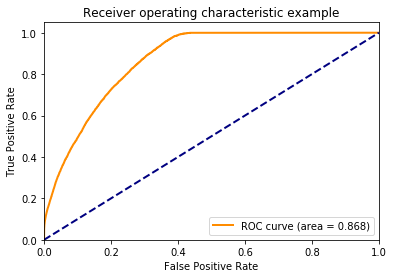

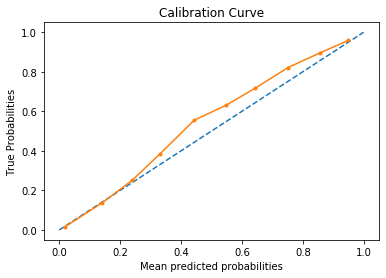

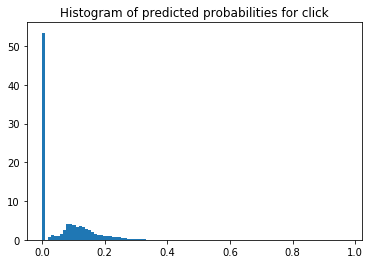

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
catboost,0.93301,0.007409,1.0,0.868186,-2.313753,0.947592,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


In [35]:
catboost_results = evaulate_pipeline(catboost_pipe, X_val, y_val, best_catboost_params)
catboost_df = pd.DataFrame(catboost_results, index= ['catboost'])
catboost_df

# Model 3: KNN Classifier 

In [36]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [37]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_accuracy = float('-inf')
    worst_accuracy = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        curr_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)

        # save if best
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_grid = g
            
        if curr_accuracy < worst_accuracy:
            worst_accuracy = curr_accuracy
            worst_grid = g
    print ("Final Result")
    print ("best accuracy", best_accuracy, ", Grid:", best_grid)
    print ("worst accuracy", worst_accuracy, ", Grid:", worst_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. weights       = should all neighbours have equal weight or weighted by the distance to the observation
3. leaf_size          = number of observations in the leafs of the tree that is used for finding the newarest neighbours



In [38]:
%%time
if CALC_PARAMS:
    knn_params_grid ={'n_neighbors': [100, 500, 1000], 
                     'weights': ['uniform', 'distance'],
                      'leaf_size' : [30,100]
                    }
    best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)
    best_knn_params
else:
    best_knn_params = get_config('knn')

{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'uniform'}
Best Threshold: 0.55 , with accuracy =  0.93252
{'leaf_size': 30, 'n_neighbors': 100, 'weights': 'distance'}
Best Threshold: 0.9644923826544576 , with accuracy =  0.92913
{'leaf_size': 30, 'n_neighbors': 500, 'weights': 'uniform'}
Best Threshold: 0.376 , with accuracy =  0.93253
{'leaf_size': 30, 'n_neighbors': 500, 'weights': 'distance'}
Best Threshold: 0.8698432695127146 , with accuracy =  0.92914
{'leaf_size': 30, 'n_neighbors': 1000, 'weights': 'uniform'}
Best Threshold: 0.34 , with accuracy =  0.93254
{'leaf_size': 30, 'n_neighbors': 1000, 'weights': 'distance'}
Best Threshold: 0.8117614058012027 , with accuracy =  0.92913
{'leaf_size': 100, 'n_neighbors': 100, 'weights': 'uniform'}
Best Threshold: 0.55 , with accuracy =  0.93252
{'leaf_size': 100, 'n_neighbors': 100, 'weights': 'distance'}
Best Threshold: 0.9644923826544576 , with accuracy =  0.92913
{'leaf_size': 100, 'n_neighbors': 500, 'weights': 'uniform'}
Best Thres

In [39]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['state', 'user_isp', 'app_cat',
                                     'banner_pos', 'manufacturer',
                                     'device_model', 'device_version',
                                     'Day_of_Week', 'Month', 'hour'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1000, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.34 , with accuracy =  0.93254


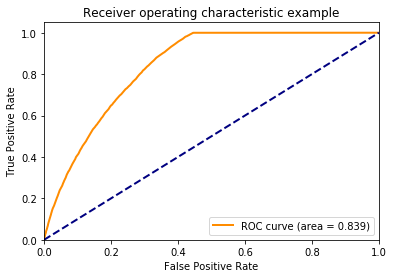

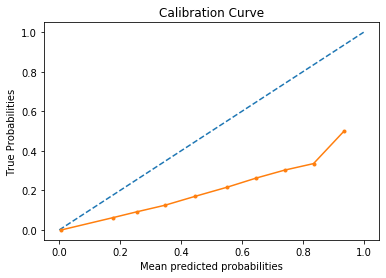

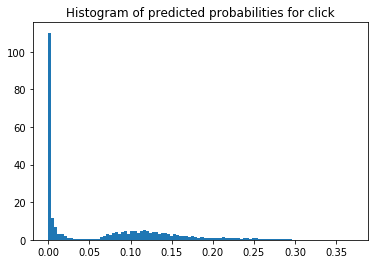

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
knn,0.93254,0.001778,0.571429,0.839289,-2.329986,0.34,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."


In [40]:
knn_results = evaulate_pipeline(knn_pipeline, X_val, y_val, best_knn_params);
knn_df = pd.DataFrame(knn_results, index= ['knn'])
knn_df

# summary of model metrics

In [41]:

metrics_df = pd.concat([rf_df, knn_df,catboost_df])
metrics_df.sort_values(by='AUC')

if CALC_PARAMS:
    now = datetime.datetime.now()
    now_string = now.strftime("%m_%d_%Y__%H_%M")
    metrics_df.reset_index().to_csv(f"configuration_{now_string}_sample_{SAMPLE}.csv", index=False)
metrics_df

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.93263,0.002963,0.714286,0.836871,-2.326877,0.220281,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."
knn,0.93254,0.001778,0.571429,0.839289,-2.329986,0.340000,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."
catboost,0.93301,0.007409,1.000000,0.868186,-2.313753,0.947592,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Exaplinable AI:  Shap Values

In [42]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

## Shap Summary Plot

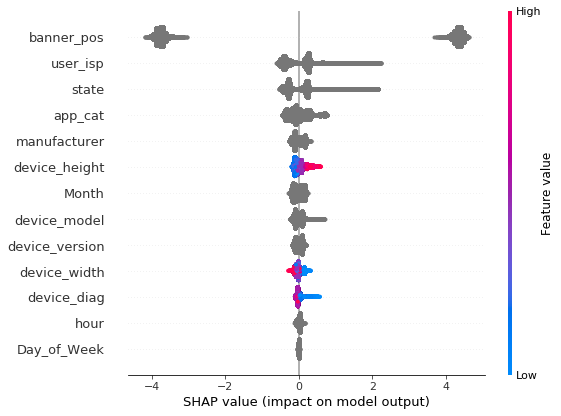

In [43]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example: TODO verify
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [44]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

# 3 random predictions local explanations

In [45]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [61]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [47]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [48]:
model = catboost_pipe
model

In [49]:
testset = pd.read_csv("ctr_dataset_test.csv")

In [50]:
%%time
X_test= testset.drop(['op_id', 'resolution','app_id'], axis=1)
X_test=process.Missing_values(X_test)
X_test=process.Feature_engineering(X_test)
X_test=process.cumulatively_categorise(X_test,columns_cum) 
X_test = X_test[features]



assert testset.shape[0] == X_test.shape[0]

summary of null values befor imputing missing data: 
timestamp              0
state                  0
user_isp               7
app_cat                0
banner_pos             0
manufacturer      193061
device_model      193011
device_version         0
device_height          0
device_width           0
dtype: int64
summary of null values after imputing missing data based on device version
timestamp           0
state               0
user_isp            0
app_cat             0
banner_pos          0
manufacturer      958
device_model      958
device_version      0
device_height       0
device_width        0
dtype: int64
summary of null values after imputing missing data as a seprate category
Wall time: 16.9 s


In [51]:
y_hat = model.predict_proba(X_test)

In [52]:
best_threshold_catboost = catboost_df['threshold'].values[0]
best_threshold_catboost

0.9475924808826166

In [53]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [54]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=182, Clicks Percent= 0.029%'

# Group 8 output

In [55]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
